In [1]:
from tqdm import tqdm
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
import h5py
import numpy as np
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import spectral_norm
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from scipy import ndimage as nd

from sklearn.decomposition import PCA

In [2]:
import os
os.chdir('../jet_data') #Move to directory with data which is 48x48
os.getcwd()

'/home/jovyan/jet_data'

In [4]:
with h5py.File('data/q_dataset.h5', 'r') as file:
    full_data = np.array(file['Data'])

x_train, x_test = train_test_split(full_data, test_size=0.25, shuffle=True)


x_train = torch.tensor(x_train).unsqueeze(1) 
x_test = torch.tensor(x_test).unsqueeze(1) 


In [5]:
var = np.var(np.mean(full_data, axis=0)[:,:,0])

In [86]:
from torch.utils.data import DataLoader, TensorDataset


class JetImageDataset(Dataset):
    def __init__(self, images):
        self.images = images.astype(np.float32)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        img = torch.from_numpy(img.squeeze(-1))
        return img


train_dataset = JetImageDataset(x_train.numpy())
test_dataset  = JetImageDataset(x_test.numpy())

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

### Model Architecture

In [87]:
class NormalizedAutoencoder(nn.Module):
    def __init__(self, latent_dim=3):
        super(NormalizedAutoencoder, self).__init__()

        self.enc_conv1 = spectral_norm(nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1, bias=True))
        self.enc_prelu1 = nn.PReLU()
        self.enc_conv2 = spectral_norm(nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1, bias=True))
        self.enc_prelu2 = nn.PReLU()
        self.enc_pool = nn.MaxPool2d(kernel_size=2, stride=2)  

        self.enc_conv3 = spectral_norm(nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1, bias=True))
        self.enc_prelu3 = nn.PReLU()
        self.enc_conv4 = spectral_norm(nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1, bias=True))
        self.enc_prelu4 = nn.PReLU()
        self.enc_conv5 = spectral_norm(nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1, bias=True))
        self.enc_prelu5 = nn.PReLU()
        self.enc_fc1 = spectral_norm(nn.Linear(576, 100, bias=True))
        self.enc_prelu_fc1 = nn.PReLU()
        self.enc_fc2 = spectral_norm(nn.Linear(100, latent_dim, bias=True))

        self.dec_fc1 = spectral_norm(nn.Linear(latent_dim, 100, bias=True))
        self.dec_prelu_fc1 = nn.PReLU()
        self.dec_fc2 = spectral_norm(nn.Linear(100, 576, bias=True))
        self.dec_prelu_fc2 = nn.PReLU()
        self.dec_deconv1 = spectral_norm(nn.ConvTranspose2d(1, 8, kernel_size=3, stride=1, padding=1, bias=True))
        self.dec_prelu1 = nn.PReLU()
        self.dec_deconv2 = spectral_norm(nn.ConvTranspose2d(8, 8, kernel_size=3, stride=1, padding=1, bias=True))
        self.dec_prelu2 = nn.PReLU()
        self.dec_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  
        self.dec_deconv3 = spectral_norm(nn.ConvTranspose2d(8, 8, kernel_size=3, stride=1, padding=1, bias=True))
        self.dec_prelu3 = nn.PReLU()
        self.dec_deconv4 = spectral_norm(nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1, bias=True))
        self.dec_sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        x = self.enc_prelu1(self.enc_conv1(x))
        x = self.enc_prelu2(self.enc_conv2(x))
        x = self.enc_pool(x)
        x = self.enc_prelu3(self.enc_conv3(x))
        x = self.enc_prelu4(self.enc_conv4(x))
        x = self.enc_prelu5(self.enc_conv5(x))
        x = x.view(x.size(0), -1)
        x = self.enc_prelu_fc1(self.enc_fc1(x))
        z = self.enc_fc2(x)
        z = F.normalize(z, p=2, dim=1)  
        return z
    
    def decode(self, z):
        x = self.dec_prelu_fc1(self.dec_fc1(z))
        x = self.dec_prelu_fc2(self.dec_fc2(x))
        x = x.view(x.size(0), 1, 24, 24)
        x = self.dec_prelu1(self.dec_deconv1(x))
        x = self.dec_prelu2(self.dec_deconv2(x))
        x = self.dec_upsample(x)
        x = self.dec_prelu3(self.dec_deconv3(x))
        x = self.dec_sigmoid(self.dec_deconv4(x))
        return x
    
    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon, z

### AE Pretraining Phase

In [88]:
device = torch.device('cuda')
model = NormalizedAutoencoder(latent_dim=3).to(device)
mse_loss = nn.MSELoss(reduction='mean')

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_pretrain_epochs = 30

for epoch in range(num_pretrain_epochs):
    model.train()
    epoch_loss = 0.0
    num_samples = 0

    for imgs in tqdm(train_loader, desc=f"AE Epoch {epoch+1}/{num_pretrain_epochs}"):
        imgs = imgs.to(device)
        variances = torch.var(imgs, dim=(2, 3), keepdim=True) + 1e-6 
        
        optimizer.zero_grad()
        recons, _ = model(imgs)
        
        loss_recon = F.mse_loss(recons, imgs) / variances  
        loss_recon = loss_recon.view(loss_recon.size(0), -1).mean(dim=1) 
        loss_recon = loss_recon.mean()  
        
        reg_loss = sum(torch.sum(param**2) for param in model.parameters())
        loss = loss_recon + 1e-5 * reg_loss  

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * imgs.size(0)
        num_samples += imgs.size(0)
    
    avg_loss = epoch_loss / num_samples
    print(f"Epoch {epoch+1}/{num_pretrain_epochs} AE Loss: {avg_loss:.6f}")


AE Epoch 1/30: 100%|██████████| 820/820 [00:11<00:00, 68.44it/s]


Epoch 1/30 AE Loss: 11.852687


AE Epoch 2/30: 100%|██████████| 820/820 [00:11<00:00, 68.73it/s]


Epoch 2/30 AE Loss: 1.149230


AE Epoch 3/30: 100%|██████████| 820/820 [00:11<00:00, 68.63it/s]


Epoch 3/30 AE Loss: 0.966397


AE Epoch 4/30: 100%|██████████| 820/820 [00:11<00:00, 68.74it/s]


Epoch 4/30 AE Loss: 0.646672


AE Epoch 5/30: 100%|██████████| 820/820 [00:11<00:00, 68.73it/s]


Epoch 5/30 AE Loss: 0.483126


AE Epoch 6/30: 100%|██████████| 820/820 [00:11<00:00, 68.73it/s]


Epoch 6/30 AE Loss: 0.438774


AE Epoch 7/30: 100%|██████████| 820/820 [00:11<00:00, 68.77it/s]


Epoch 7/30 AE Loss: 0.416311


AE Epoch 8/30: 100%|██████████| 820/820 [00:11<00:00, 68.70it/s]


Epoch 8/30 AE Loss: 0.403938


AE Epoch 9/30: 100%|██████████| 820/820 [00:11<00:00, 68.90it/s]


Epoch 9/30 AE Loss: 0.396553


AE Epoch 10/30: 100%|██████████| 820/820 [00:11<00:00, 68.67it/s]


Epoch 10/30 AE Loss: 0.391825


AE Epoch 11/30: 100%|██████████| 820/820 [00:11<00:00, 68.73it/s]


Epoch 11/30 AE Loss: 0.389789


AE Epoch 12/30: 100%|██████████| 820/820 [00:11<00:00, 68.64it/s]


Epoch 12/30 AE Loss: 0.388804


AE Epoch 13/30: 100%|██████████| 820/820 [00:11<00:00, 68.66it/s]


Epoch 13/30 AE Loss: 0.386114


AE Epoch 14/30: 100%|██████████| 820/820 [00:11<00:00, 68.53it/s]


Epoch 14/30 AE Loss: 0.384033


AE Epoch 15/30: 100%|██████████| 820/820 [00:11<00:00, 68.68it/s]


Epoch 15/30 AE Loss: 0.382361


AE Epoch 16/30: 100%|██████████| 820/820 [00:11<00:00, 68.54it/s]


Epoch 16/30 AE Loss: 0.336273


AE Epoch 17/30: 100%|██████████| 820/820 [00:11<00:00, 68.76it/s]


Epoch 17/30 AE Loss: 0.283981


AE Epoch 18/30: 100%|██████████| 820/820 [00:11<00:00, 68.61it/s]


Epoch 18/30 AE Loss: 0.257982


AE Epoch 19/30: 100%|██████████| 820/820 [00:11<00:00, 68.82it/s]


Epoch 19/30 AE Loss: 0.244692


AE Epoch 20/30: 100%|██████████| 820/820 [00:11<00:00, 68.70it/s]


Epoch 20/30 AE Loss: 0.232642


AE Epoch 21/30: 100%|██████████| 820/820 [00:11<00:00, 68.67it/s]


Epoch 21/30 AE Loss: 0.225771


AE Epoch 22/30: 100%|██████████| 820/820 [00:11<00:00, 68.70it/s]


Epoch 22/30 AE Loss: 0.221798


AE Epoch 23/30: 100%|██████████| 820/820 [00:11<00:00, 68.75it/s]


Epoch 23/30 AE Loss: 0.219458


AE Epoch 24/30: 100%|██████████| 820/820 [00:11<00:00, 68.63it/s]


Epoch 24/30 AE Loss: 0.213827


AE Epoch 25/30: 100%|██████████| 820/820 [00:11<00:00, 68.69it/s]


Epoch 25/30 AE Loss: 0.214582


AE Epoch 26/30: 100%|██████████| 820/820 [00:11<00:00, 68.74it/s]


Epoch 26/30 AE Loss: 0.212204


AE Epoch 27/30: 100%|██████████| 820/820 [00:11<00:00, 68.48it/s]


Epoch 27/30 AE Loss: 0.208999


AE Epoch 28/30: 100%|██████████| 820/820 [00:11<00:00, 68.85it/s]


Epoch 28/30 AE Loss: 0.202697


AE Epoch 29/30:  90%|█████████ | 740/820 [00:10<00:01, 68.92it/s]

In [62]:
torch.save(model.state_dict(), "model_postAEtrain.pth")

### NAE Training Phase

In [60]:
model.train()

latent_steps = 30
latent_step_size = 50 #0.1#50#0.1#5#0#0.1
latent_noise_std = 10**-4 #0.1 #10**-4#0.1#0.0001#0.1
num_nae_iterations = 500
latent_buffer = []   
buffer_size = 10000

optimizer = optim.Adam(model.parameters(), lr=1e-5)

pbar = tqdm(range(num_nae_iterations), desc="NAE Training")
for it in pbar:
    imgs = next(iter(train_loader)).to(device)
    
    variances = torch.var(imgs, dim=(2,3), keepdim=True) + 1e-6  
    
    optimizer.zero_grad()
    recons, z = model(imgs)
    E_pos = mse_loss(recons, imgs) / variances
    E_pos = E_pos.view(E_pos.size(0), -1).mean(dim=1)
    E_pos = E_pos.mean()
    
    batch_size = imgs.size(0)
    if latent_buffer and np.random.rand() < 0.95:
        idx = np.random.randint(len(latent_buffer), size=batch_size)
        z_neg = torch.tensor(np.array(latent_buffer)[idx], dtype=torch.float32, device=device)
    else:
        z_rand = torch.randn((batch_size, 3), device=device)
        z_neg = F.normalize(z_rand, p=2, dim=1)
    z_neg.requires_grad_(True)
    
    for _ in range(latent_steps):
        x_neg = model.decode(z_neg)
        x_neg_enc = model.encode(x_neg)
        x_neg_recon = model.decode(x_neg_enc)
        energy = mse_loss(x_neg_recon, x_neg) / variances
        energy = energy.view(energy.size(0), -1).mean(dim=1)
        grad_z = torch.autograd.grad(energy.mean(), z_neg, retain_graph=False, create_graph=False)[0]
        z_neg = z_neg - 0.5 * latent_step_size * grad_z + latent_noise_std * torch.randn_like(z_neg)
        z_neg = F.normalize(z_neg, p=2, dim=1)
        z_neg.requires_grad_(True)
    x_neg_final = model.decode(z_neg.detach())
    x_neg_recon_final, _ = model(x_neg_final)
    E_neg = mse_loss(x_neg_recon_final, x_neg_final) / variances
    E_neg = E_neg.view(E_neg.size(0), -1).mean(dim=1)
    E_neg = E_neg.mean()
    
    reg_loss = sum(torch.sum(param**2) for param in model.parameters())
    loss = E_pos - E_neg + 1e-5 * reg_loss + 1e-3 * (E_pos**2)
    loss.backward()
    optimizer.step()
    
    pbar.set_postfix({
        "loss": f"{loss.item():.6f}",
        "E_pos": f"{E_pos.item():.6f}",
        "E_neg": f"{E_neg.item():.6f}"
    })
    

    if len(latent_buffer) < buffer_size:
        latent_buffer.extend(z_neg.detach().cpu().numpy())
    else:
        replace_idx = np.random.randint(buffer_size, size=batch_size)
        arr = np.array(latent_buffer)
        arr[replace_idx] = z_neg.detach().cpu().numpy()
        latent_buffer = list(arr)
torch.save(model.state_dict(), "model_postNAEtrain.pth")

NAE Training: 100%|██████████| 500/500 [02:41<00:00,  3.09it/s, loss=0.232654, E_pos=0.241808, E_neg=0.012918]


### Test Model 

In [16]:
signal_labels = ["g", "t", "w", "z"]
signals_file = ["data/g_dataset.h5", "data/t_dataset.h5", "data/w_dataset.h5", "data/z_dataset.h5"]
signal_data = []


for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file['Data'])
    signal_data.append(torch.tensor(test_data).unsqueeze(1))

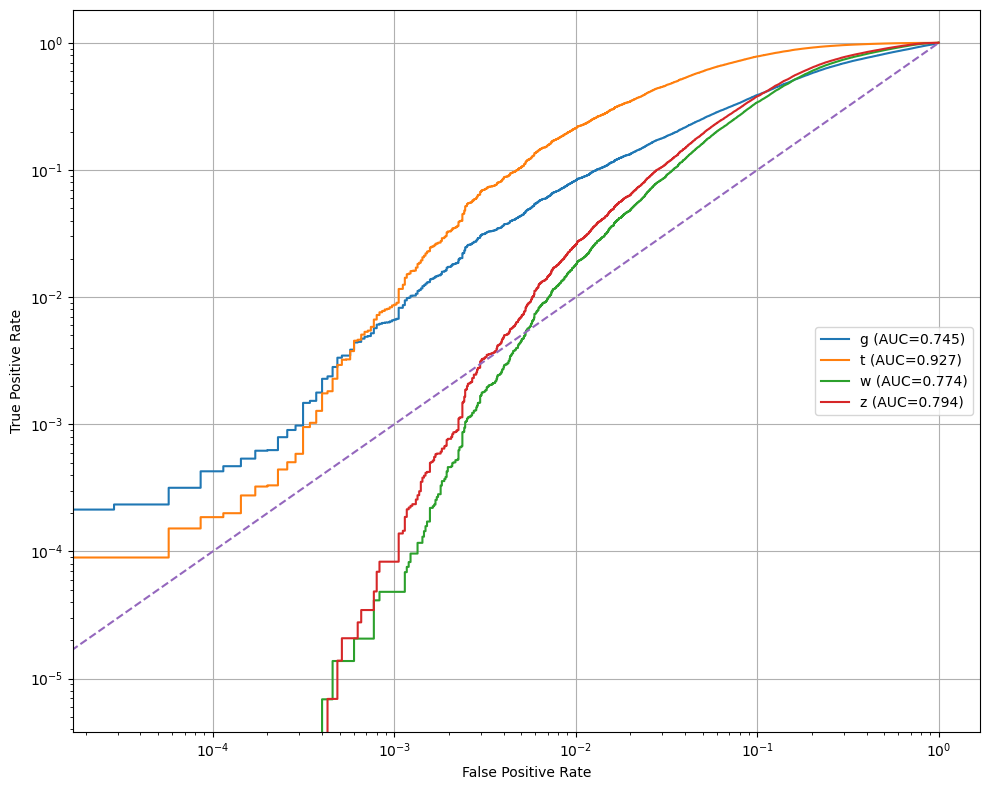

In [75]:

model.eval()

def compute_anomaly_loss(loader, model, device):
    loss = []
    with torch.no_grad():
        for imgs in loader:
            imgs = imgs.to(device)
            variances = np.var(imgs.cpu().numpy(), axis=(2,3), keepdims=True) + 1e-6  
            variances = torch.tensor(variances, dtype=torch.float32, device=imgs.device)          
            recons, _ = model(imgs)
            err = F.mse_loss(recons, imgs)  
            err = err / variances  
            err = err.view(err.size(0), -1).mean(dim=1)
            loss.extend(err.cpu().numpy())
            
    return np.array(loss)


bkg_loss = compute_anomaly_loss(test_loader, model, device)


signal_loss = []
for data in signal_data:
    dataset = JetImageDataset(data.numpy())
    loader = DataLoader(dataset, batch_size=128, shuffle=False)
    loss = compute_anomaly_loss(loader, model, device)
    signal_loss.append(loss)



plt.figure(figsize=(10, 8))

for i, label in enumerate(signal_labels):
    pos = signal_loss[i]
    neg = bkg_loss
    trueVal = np.concatenate((np.ones(len(pos)), np.zeros(len(neg))))
    predVal_loss = np.concatenate((pos, neg))
    fpr, tpr, thresholds = roc_curve(trueVal, predVal_loss)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_val:.3f})")
    
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()
plt.show()

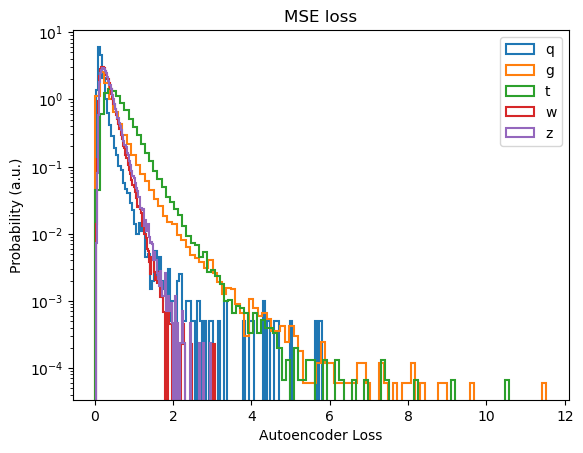

In [76]:
plt.hist(bkg_loss, bins=100, label='q', density = True, histtype='step', fill=False, linewidth=1.5, )
for i, label in enumerate(signal_labels):
    plt.hist(signal_loss[i], bins=100, label=label, density = True, histtype='step', fill=False, linewidth=1.5, )
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()